# 定义神经网络的框架

In [1]:
import numpy
import scipy.special


# neural network definition
class NeuralNetwork:

    # initialise the neural network
    def __init__(self, numInputNodes, numHidden1Nodes, numHidden2Nodes, numOutputNodes, learningRate):
        # 单隐藏层示例，设置各层的节点个数
        self.numInputNodes = numInputNodes
        self.numHidden1Nodes = numHidden1Nodes
        self.numHidden2Nodes = numHidden2Nodes
        self.numOutputNodes = numOutputNodes

        # 权重更新时的学习率
        self.learningRate = learningRate

        # 正态分布初始化权重
        self.weightInputHidden = numpy.random.normal(0.0, pow(self.numHidden1Nodes, -0.5),
                                                     (self.numHidden1Nodes, self.numInputNodes))
        self.weightHidden1Output = numpy.random.normal(0.0, pow(self.numHidden2Nodes, -0.5),
                                                      (self.numHidden2Nodes, self.numHidden1Nodes))
        self.weightHidden2Output = numpy.random.normal(0.0, pow(self.numOutputNodes, -0.5),
                                                      (self.numOutputNodes, self.numHidden2Nodes))

        # 激活函数(lambda创建匿名函数)
        self.activation_function = lambda x: scipy.special.expit(x)
        pass

    # train the network using training data set
    def training(self, inputs_list, targets_list):
        # 第一，同query()函数
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        hidden1_inputs = numpy.dot(self.weightInputHidden, inputs)
        hidden1_outputs = self.activation_function(hidden1_inputs)
        hidden2_inputs = numpy.dot(self.weightHidden1Output, hidden1_outputs)
        hidden2_outputs = self.activation_function(hidden2_inputs)
        final_inputs = numpy.dot(self.weightHidden2Output, hidden2_outputs)
        final_outputs = self.activation_function(final_inputs)

        # 计算误差
        output_errors = targets - final_outputs
        # 反向传播误差到隐藏层2
        hidden2_errors = numpy.dot(self.weightHidden2Output.T, output_errors)
        # 反向传播误差到隐藏层1
        hidden1_errors = numpy.dot(self.weightHidden1Output.T, hidden2_errors)

        # 更新隐藏层2和输出层之间的权重
        self.weightHidden2Output += self.learningRate * numpy.dot((output_errors * final_outputs *
                                                                  (1.0 - final_outputs)),
                                                                 numpy.transpose(hidden2_outputs))
        # 更新隐藏层2和隐藏层1之间的权重
        self.weightHidden1Output += self.learningRate * numpy.dot((hidden2_errors * hidden2_outputs *
                                                                  (1.0 - hidden2_outputs)),
                                                                 numpy.transpose(hidden1_outputs))
        # 更新输入层和隐藏层1之间的权重
        self.weightInputHidden += self.learningRate * numpy.dot((hidden1_errors * hidden1_outputs *
                                                                 (1.0 - hidden1_outputs)),
                                                                numpy.transpose(inputs))

        pass

    # query the network using test data set
    def query(self, inputs_list):
        # 将输入一维数组转化成二维，并转置
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # 计算到达隐藏层1的信号，即隐藏层1输入
        hidden1_inputs = numpy.dot(self.weightInputHidden, inputs)
        # 计算隐藏层1的输出，即经过sigmoid函数的输出
        hidden1_outputs = self.activation_function(hidden1_inputs)

        # 计算到达隐藏层2的信号，即隐藏层2输入
        hidden2_inputs = numpy.dot(self.weightHidden1Output, hidden1_outputs)
        # 计算隐藏层2的输出，即经过sigmoid函数的输出
        hidden2_outputs = self.activation_function(hidden2_inputs)
        

        # 计算到达输出层的信号，即输出层的输入
        final_inputs = numpy.dot(self.weightHidden2Output, hidden2_outputs)
        # 计算最终的输出
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

# 识别手写数字数据集MNIST

## 解压数据集

In [2]:
!cp -r /content/drive/My\ Drive/mnist_dataset.zip ./  #将google云盘中的数据集压缩文件拷贝到当前运行环境
!unzip mnist_dataset.zip  #将数据集压缩文件解压

Archive:  mnist_dataset.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


## 直观的展示数据



选择数据集中的一条记录，将这张手写数字图片绘制出来：

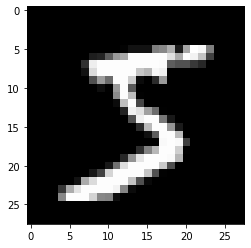

In [3]:
import matplotlib.pyplot as plt

# 直接使用plt.imshow无法显示图片，需要导入pylab包
import pylab

# 打开并读取文件
data_file = open("mnist_train.csv")
data_list = data_file.readlines()
data_file.close()

# 拆分绘制28*28图形
all_pixels = data_list[0].split(',')
image_array = numpy.asfarray(all_pixels[1:]).reshape((28, 28))
plt.figure("Image")
plt.imshow(image_array, cmap='gray', interpolation='None')
pylab.show()

# 训练&测试

In [5]:
import time

# 便于计算执行时间
start = time.process_time()

# 指定神经网络的结构。隐藏层节点个数不唯一
input_nodes, hidden1_nodes, hidden2_nodes, output_nodes = 784, 256, 100, 10

# 指定权重更新的学习率
learning_rate = 0.3

# 创建神经网络的实例
network = NeuralNetwork(input_nodes, hidden1_nodes, hidden2_nodes, output_nodes, learning_rate)

# 读取训练数据，只读方式
training_data_file = open("mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

# 训练神经网络，epochs次
epochs = 10
for e in range(epochs):
    for record in training_data_list:
        # 缩放输入
        all_pixels = record.split(',')
        scaled_inputs = (numpy.asfarray(all_pixels[1:]) / 255.0 * 0.99) + 0.01
        # 创建目标输出
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_pixels[0])] = 0.99
        network.training(scaled_inputs, targets)
        pass
    pass

# 读取测试数据集
test_data_file = open("mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

# 测试训练好的神经网络
# 初始化一个数据结构用于记录神经网络的表现
scorecard = []
# 遍历测试数据集
for record in test_data_list:
    # 打印预期输出
    all_pixels = record.split(',')
    correct_label = int(all_pixels[0])
    # 查询神经网络
    inputs = (numpy.asfarray(all_pixels[1:])/255.0 * 0.99) + 0.01
    outputs = network.query(inputs)
    answer = numpy.argmax(outputs)
    # 更新神经网络的表现
    if answer == correct_label:
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass
    pass

# 打印得分及运行时间
print("time: ", time.process_time()-start)
print("performance: ", sum(scorecard) / len(scorecard))

time:  1477.13756212
performance:  0.8012
